# MODELO DE INTELIGENCIA ARTIFICIAL - APRENDIZAJE NO SUPERVISADO

🚗 Clasificación de vueltas rápidas en datos de carreras de Fórmula 1

En este Notebook se desarrollará un modelo inteligente capaz de agrupar en clústers vueltas de pilotos de Fórmula 1 durante el GP de España 2025, con el fin de encontrar patrones en esos datos y analizar el resultado del modelo. El problema se abordará como una tarea de **clustering**, utilizando un dataset obtenido de Kaggle, el cual contiene diversas variables numéricas relacionadas con la carrera, tales como:

* El tiempo de cada vuelta de cada piloto durante la carrera.

* El tiempo de cada vuelta por sectores.

* La posición del piloto en cada vuelta.

Entre otras características relevantes.

🧩 Enfoque metodológico

Con el objetivo de alcanzar la mayor precisión posible, se realizará un proceso de **preprocesamiento exhaustivo de los datos**, identificando y tratando adecuadamente las variables numéricas más relevantes del problema, tratando de conservar en todo momento una escala adecuada al tratar con datos en segundos que pueden suponer un sesgo importante para el modelo, según hemos estudiado durante el temario y comprobado en el proyecto de aprendizaje supervisado.

Asimismo, se evaluará la posibilidad de generar versiones alternativas del dataset, modificando o codificando de distintas formas las variables, con el fin de analizar su impacto en el rendimiento del modelo.

Al tratarse de un problema de **clustering**, se estudiará cómo la utilización de diferentes algoritmos afecta al correcto funcionamiento del modelo, así como:

* K-Means.

* DBSCAN.

* Clustering Jerárquico.

* GMM.

El rendimiento de cada modelo será evaluado para determinar cuál proporciona la mejor capacidad de agrupamiento en este contexto.

📊 Evaluación del modelo

Finalmente, se realizará un **análisis detallado de los resultados** comparando las métricas entre algoritmos. Se calcularán y compararán métricas clásicas de agrupamiento, tales como:

* Silhouette Score.

* Inertia.

* Davies-Bouldin Index.

Además, se incluirán gráficos comparativos entre los diferentes algoritmos, permitiendo evaluar de un vistazo qué modelo ofrece mejor rendimiento según las métricas consideradas.

Una vez elegido el modelo final en base a este análisis de forma totalmente crítica (lo importante es entender qué te dice cada métrica de evaluación y por qué, en este problema, es más importante atender a según cuál), se visualizarán sus resultados con gráficos detallados.

Todos los resultados serán interpretados en lenguaje natural, permitiendo una comprensión clara y la valoración de la efectividad del modelo desarrollado.


In [136]:
# 1. Importar las librerías necesarias

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.neighbors import NearestNeighbors
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, davies_bouldin_score
import scipy.cluster.hierarchy as sch

print("Librerías importadas correctamente.")

Librerías importadas correctamente.


In [ ]:
# 2. Cargar el dataset

data = pd.read_csv('./data/lap_times_2025_round_9.csv')
df = data.copy()
print("Dataset cargado correctamente. ✅")
print(f"Número de filas: {df.shape[0]}")
print(f"Número de columnas: {df.shape[1]}")
df.head(n=10)

Dataset cargado correctamente. ✅
Número de filas: 1203
Número de columnas: 8


,Driver,Lap Number,Lap Time,Position,Time,Sector 1,Sector 2,Sector 3
0,VER,1.0,0 days 00:01:23.696000,2.0,0 days 01:00:37.344000,NaN,0 days 00:00:32.318000,0 days 00:00:24.013000
1,VER,2.0,0 days 00:01:20.083000,2.0,0 days 01:01:57.427000,0 days 00:00:24.125000,0 days 00:00:32.278000,0 days 00:00:23.680000
2,VER,3.0,0 days 00:01:20.537000,2.0,0 days 01:03:17.964000,0 days 00:00:23.816000,0 days 00:00:32.561000,0 days 00:00:24.160000
3,VER,4.0,0 days 00:01:21.032000,2.0,0 days 01:04:38.996000,0 days 00:00:24.299000,0 days 00:00:32.612000,0 days 00:00:24.121000
4,VER,5.0,0 days 00:01:20.964000,2.0,0 days 01:05:59.960000,0 days 00:00:24.223000,0 days 00:00:32.561000,0 days 00:00:24.180000
5,VER,6.0,0 days 00:01:20.822000,2.0,0 days 01:07:20.782000,0 days 00:00:23.966000,0 days 00:00:32.687000,0 days 00:00:24.169000
6,VER,7.0,0 days 00:01:20.760000,2.0,0 days 01:08:41.542000,0 days 00:00:23.968000,0 days 00:00:32.520000,0 days 00:00:24.272000
7,VER,8.0,0 days 00:01:21.019000,2.0,0 days 01:10:02.561000,0 days 00:00:24.105000,0 days 00:00:32.719000,0 days 00:00:24.195000
8,VER,9.0,0 days 00:01:21.168000,2.0,0 days 01:11:23.729000,0 days 00:00:24.033000,0 days 00:00:32.833000,0 days 00:00:24.302000
9,VER,10.0,0 days 00:01:21.163000,2.0,0 days 01:12:44.892000,0 days 00:00:24.018000,0 days 00:00:32.814000,0 days 00:00:24.331000


Como podemos observar, encontramos dos problemas principales en el dataset:

* En primer lugar, se detectan columnas con valores nulos, probablemente correspondientes a las primeras vueltas de cada piloto durante el Gran Premio, así como a posibles abandonos (DNF) ocurridos durante la carrera. Sería conveniente revisar el número exacto de muestras con valores nulos y, en función de su proporción, decidir si conviene eliminarlas o imputar los valores faltantes con medidas estadísticas. En este último caso, se pasaría a analizar la distribución de cada variable: si los valores máximos son muy dispares respecto al resto (indicando la presencia de outliers), resultará más apropiado imputar con la mediana, mientras que si los datos presentan una distribución más homogénea, la media será una opción válida.

* En segunda lugar, los campos relacionados con el tiempo (tiempo total de vuelta y tiempos por sector) representan diferencias temporales, por lo que lo más adecuado es convertirlos a segundos puros. Esto facilita tanto el análisis como el posterior tratamiento en los modelos de machine learning.

In [138]:
# 3. Eliminar columnas innecesarias

# Solo eliminamos la columna con el nombre del piloto, el cual es irrelevante para el procesamiento del modelo
columns_to_drop = [
    'Driver'
]

df.drop(columns=columns_to_drop, inplace=True)
df.head(n=10)

,Lap Number,Lap Time,Position,Time,Sector 1,Sector 2,Sector 3
0,1.0,0 days 00:01:23.696000,2.0,0 days 01:00:37.344000,NaN,0 days 00:00:32.318000,0 days 00:00:24.013000
1,2.0,0 days 00:01:20.083000,2.0,0 days 01:01:57.427000,0 days 00:00:24.125000,0 days 00:00:32.278000,0 days 00:00:23.680000
2,3.0,0 days 00:01:20.537000,2.0,0 days 01:03:17.964000,0 days 00:00:23.816000,0 days 00:00:32.561000,0 days 00:00:24.160000
3,4.0,0 days 00:01:21.032000,2.0,0 days 01:04:38.996000,0 days 00:00:24.299000,0 days 00:00:32.612000,0 days 00:00:24.121000
4,5.0,0 days 00:01:20.964000,2.0,0 days 01:05:59.960000,0 days 00:00:24.223000,0 days 00:00:32.561000,0 days 00:00:24.180000
5,6.0,0 days 00:01:20.822000,2.0,0 days 01:07:20.782000,0 days 00:00:23.966000,0 days 00:00:32.687000,0 days 00:00:24.169000
6,7.0,0 days 00:01:20.760000,2.0,0 days 01:08:41.542000,0 days 00:00:23.968000,0 days 00:00:32.520000,0 days 00:00:24.272000
7,8.0,0 days 00:01:21.019000,2.0,0 days 01:10:02.561000,0 days 00:00:24.105000,0 days 00:00:32.719000,0 days 00:00:24.195000
8,9.0,0 days 00:01:21.168000,2.0,0 days 01:11:23.729000,0 days 00:00:24.033000,0 days 00:00:32.833000,0 days 00:00:24.302000
9,10.0,0 days 00:01:21.163000,2.0,0 days 01:12:44.892000,0 days 00:00:24.018000,0 days 00:00:32.814000,0 days 00:00:24.331000


In [139]:
# 4. Visualizar el número de valores nulos que encontramos en el dataset

# Obtenemos el número total de filas con al menos 1 valor nulo
df.isnull().any(axis=1).sum()

np.int64(20)

Como podemos observar, solo tenemos 20 filas con valores nulos, por lo que en este caso lo mejor va a ser directamente eliminar esas muestras, ya que nuestro dataset tiene un total de 1203 muestras. En este caso, eliminar 20 de ellas será irrelevante.

In [140]:
# 5. Eliminar filas con valores nulos

print(f"Filas antes de eliminar aquellas con valores nulos: {df.shape[0]}")
df.dropna(axis=0, thresh=int(df.shape[1]), inplace=True)
print(f"Filas después de eliminar aquellas con valores nulos: {df.shape[0]}")
df.head(n=10)

Filas antes de eliminar aquellas con valores nulos: 1203
Filas después de eliminar aquellas con valores nulos: 1183


,Lap Number,Lap Time,Position,Time,Sector 1,Sector 2,Sector 3
1,2.0,0 days 00:01:20.083000,2.0,0 days 01:01:57.427000,0 days 00:00:24.125000,0 days 00:00:32.278000,0 days 00:00:23.680000
2,3.0,0 days 00:01:20.537000,2.0,0 days 01:03:17.964000,0 days 00:00:23.816000,0 days 00:00:32.561000,0 days 00:00:24.160000
3,4.0,0 days 00:01:21.032000,2.0,0 days 01:04:38.996000,0 days 00:00:24.299000,0 days 00:00:32.612000,0 days 00:00:24.121000
4,5.0,0 days 00:01:20.964000,2.0,0 days 01:05:59.960000,0 days 00:00:24.223000,0 days 00:00:32.561000,0 days 00:00:24.180000
5,6.0,0 days 00:01:20.822000,2.0,0 days 01:07:20.782000,0 days 00:00:23.966000,0 days 00:00:32.687000,0 days 00:00:24.169000
6,7.0,0 days 00:01:20.760000,2.0,0 days 01:08:41.542000,0 days 00:00:23.968000,0 days 00:00:32.520000,0 days 00:00:24.272000
7,8.0,0 days 00:01:21.019000,2.0,0 days 01:10:02.561000,0 days 00:00:24.105000,0 days 00:00:32.719000,0 days 00:00:24.195000
8,9.0,0 days 00:01:21.168000,2.0,0 days 01:11:23.729000,0 days 00:00:24.033000,0 days 00:00:32.833000,0 days 00:00:24.302000
9,10.0,0 days 00:01:21.163000,2.0,0 days 01:12:44.892000,0 days 00:00:24.018000,0 days 00:00:32.814000,0 days 00:00:24.331000
10,11.0,0 days 00:01:21.143000,2.0,0 days 01:14:06.035000,0 days 00:00:23.996000,0 days 00:00:32.812000,0 days 00:00:24.335000


In [141]:
# 5. Pasar las diferencias temporales a segundos puros

columns_to_seconds = [
    "Lap Time", "Time", "Sector 1", "Sector 2", "Sector 3"
]

for column in columns_to_seconds:
    df[column] = pd.to_timedelta(df[column])
    df[column] = df[column].dt.total_seconds()

df.head(n=10)

,Lap Number,Lap Time,Position,Time,Sector 1,Sector 2,Sector 3
1,2.0,80.083,2.0,3717.427,24.125,32.278,23.680
2,3.0,80.537,2.0,3797.964,23.816,32.561,24.160
3,4.0,81.032,2.0,3878.996,24.299,32.612,24.121
4,5.0,80.964,2.0,3959.960,24.223,32.561,24.180
5,6.0,80.822,2.0,4040.782,23.966,32.687,24.169
6,7.0,80.760,2.0,4121.542,23.968,32.520,24.272
7,8.0,81.019,2.0,4202.561,24.105,32.719,24.195
8,9.0,81.168,2.0,4283.729,24.033,32.833,24.302
9,10.0,81.163,2.0,4364.892,24.018,32.814,24.331
10,11.0,81.143,2.0,4446.035,23.996,32.812,24.335


Lo siguiente es normalizar/escalar nuestros datos, al presentar escalas totalmente diferentes: los tiempos por vuelta apenas duran en torno a 80 segundos en las 10 primeras columnas y los tiempos de carrera se presentan en torno a los 4000 segundos. Para saber si es mejor estandarizar o normalizar los datos, sería conveniente ver la distribución de los mismos y los valores máximos y mínimos que presenta cada feature.

In [142]:
# 6. Comprobar valores máximos y mínimos de cada feature

df.agg(["min", "max"])

,Lap Number,Lap Time,Position,Time,Sector 1,Sector 2,Sector 3
min,2.0,75.743,1.0,3716.738,22.500,30.476,22.567
max,66.0,148.794,19.0,9163.220,59.458,60.126,42.193


Como podemos observar, se presentan presuntos valores atípicos en features que no eran esperados. En *Lap Number* y *Position* sí se esperaban esos rangos, al ser features con distribuciones uniformes de datos, pero en el resto no se esperaban esos valores máximos con respecto a los mínimos. Por eso, y antes de decidir si normalizar o estandarizar nuestros datos, sería correcto representar gráficamente esas features para analizar cómo es la distribución del dataset.

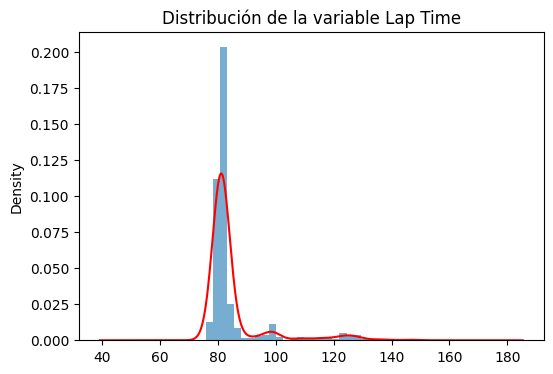

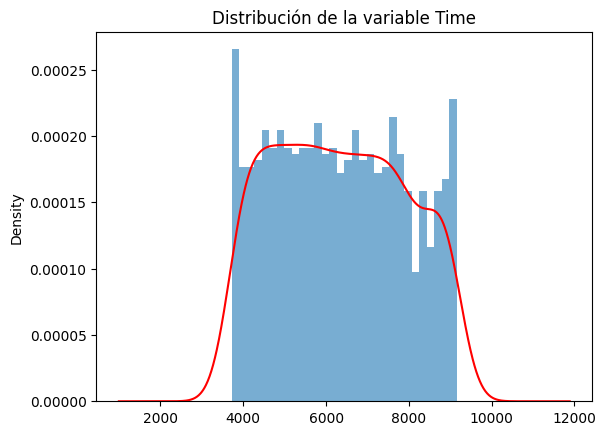

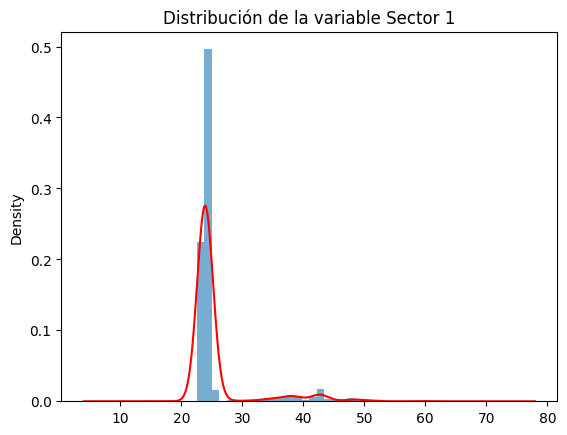

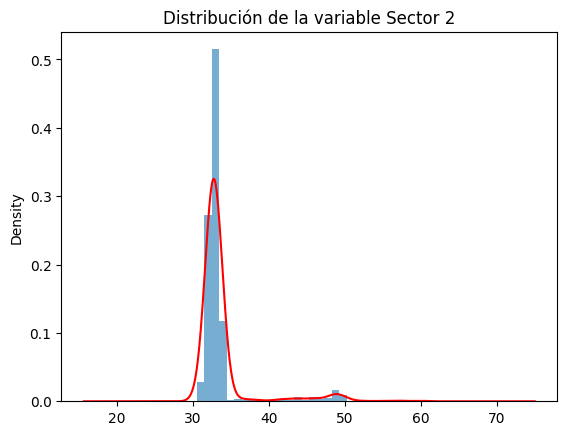

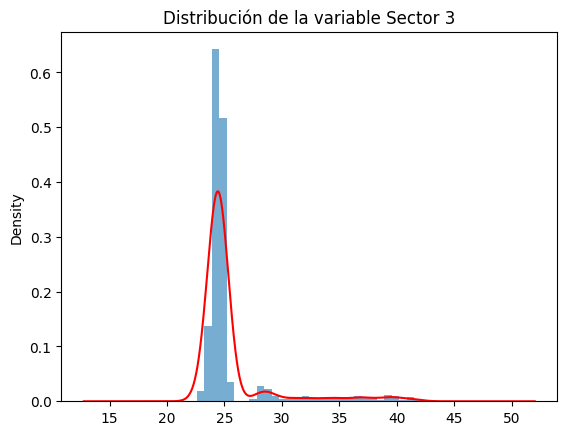

In [143]:
# 7. Representar gráficamente aquellas columnas con valores presuntamente atípicos

features_to_study = [
    "Lap Time", "Time", "Sector 1", "Sector 2", "Sector 3"
]

plt.figure(figsize=(6, 4))

for feature in features_to_study:
    df[feature].plot(kind="hist", bins=30, density=True, alpha=0.6)
    df[feature].plot(kind="kde", color="red")
    plt.title(f"Distribución de la variable {feature}")
    plt.show()

Según las gráficas (histograma y curva de densidad), podemos extraer las siguientes conclusiones:

* En los features de *Lap Time*, *Sector 1*, *Sector 2* y *Sector 3*, podemos observar como los datos siguen una distribución aproximadamente gaussiana con cola larga hacia la derecha, lo que marca la existencia de outliers que están presentes en una mínima medida dentro del dataset. Por eso, lo mejor sería escalar los datos con un algoritmo de estandarización como **RobustScaler**, que nos permite escalar los datos en torno a la mediana de la distribución y según el rango intercuartílico (IQR).

* En *Time*, se observa como se sigue una distribución gaussiana (normal) sin outliers de ningún tipo, con todos los datos concentrados de manera controlada. Esto nos permite poder escalar los datos con una medida de estandarización como **StandardScaler**, distribuyendo los datos en torno a la media y escalándolos en función de la desviación típica.

* Por último, en el resto de features (*Lap Number* y *Position*) podremos escalar los datos con un algoritmo de normalización, con escala entre 0 y 1, como **MinMax**, al seguir los datos una distribución numérica uniforme.

In [144]:
# 8. Escalar los datos con los distintos algoritmos correspondientes.

robust_scaler = RobustScaler()
standard_scaler = StandardScaler()
minmax_scaler = MinMaxScaler()

df_scaled = df.copy()

df_scaled[["Lap Time", "Sector 1", "Sector 2", "Sector 3"]] = robust_scaler.fit_transform(df_scaled[["Lap Time", "Sector 1", "Sector 2", "Sector 3"]])
df_scaled[["Time"]] = standard_scaler.fit_transform(df_scaled[["Time"]])
df_scaled[["Lap Number", "Position"]] = minmax_scaler.fit_transform(df_scaled[["Lap Number", "Position"]])

df_scaled.head(n=10)

,Lap Number,Lap Time,Position,Time,Sector 1,Sector 2,Sector 3
1,0.000000,-0.607767,0.055556,-1.657583,0.316667,-0.543384,-1.209474
2,0.015625,-0.401544,0.055556,-1.606409,-0.255556,-0.236443,-0.498890
3,0.031250,-0.176698,0.055556,-1.554920,0.638889,-0.181128,-0.556625
4,0.046875,-0.207586,0.055556,-1.503474,0.498148,-0.236443,-0.469282
5,0.062500,-0.272087,0.055556,-1.452119,0.022222,-0.099783,-0.485566
6,0.078125,-0.300250,0.055556,-1.400803,0.025926,-0.280911,-0.333087
7,0.093750,-0.182603,0.055556,-1.349322,0.279630,-0.065076,-0.447076
8,0.109375,-0.114922,0.055556,-1.297747,0.146296,0.058568,-0.288675
9,0.125000,-0.117193,0.055556,-1.246175,0.118519,0.037961,-0.245744
10,0.140625,-0.126278,0.055556,-1.194615,0.077778,0.035792,-0.239822


In [145]:
# 9. Comprobar los valores mínimos y máximos nuevamente de nuestro dataset

df_scaled.agg(["min", "max"])

,Lap Number,Lap Time,Position,Time,Sector 1,Sector 2,Sector 3
min,0.0,-2.579151,0.0,-1.658021,-2.692593,-2.497831,-2.857143
max,1.0,30.603225,1.0,1.802751,65.748148,29.660521,26.196891


Lo siguiente es determinar el número óptimo de clústers para nuestro modelo. Para ello, aplicaremos el método del codo (**Elbow Method**), que consiste en entrenar el algoritmo de K-Means variando el número de clústers (k) dentro de un rango (en este caso, de 1 a 10).

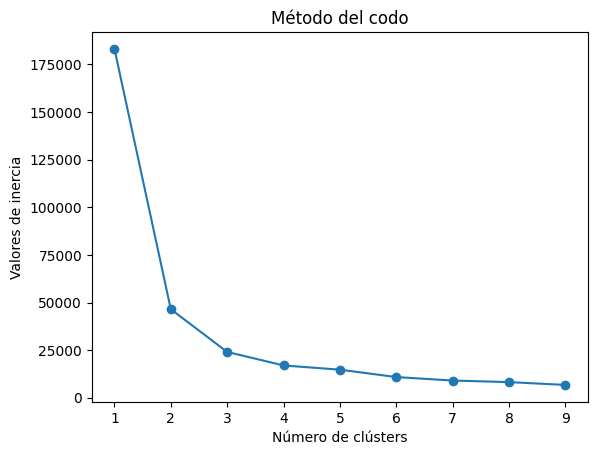

In [146]:
# 10. Calcular y expresar gráficamente la inertia de cada modelo con k clusters en un rango de entre 1 y 10

inertia_values = []
K = range(1, 10)

for k in K:
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(df_scaled)
    inertia_values.append(km.inertia_)

plt.plot(K, inertia_values, marker="o")
plt.xlabel("Número de clústers")
plt.ylabel("Valores de inercia")
plt.title("Método del codo")
plt.show()


Como se puede observar en el gráfico, la inercia del modelo disminuye más rápidamente al pasar de 1 a 2 clústers, indicando la mayor ganancia al dividir los datos en dos grupos. Entre 2 y 3 clústers la reducción comienza a desacelerarse, y a partir de 3 clústers la inercia se estabiliza casi por completo, mostrando que añadir más clústers no aporta mejoras significativas.

👉 En consecuencia, el número óptimo de clústers para nuestro dataset es 2, ya que representa el punto donde la mayor parte de la estructura de los datos queda capturada de forma eficiente.

Además, para el caso del algoritmo DBSCAN, sería necesario calcular el radio de vencidad más óptimo para nuestro dataset. Para ello, utilizaremos también el método del codo utilizando el algoritmo **NearestNeighbors** a través de un gráfico de distancias k-vecinos con min_samples igual al número de features + 1. Esto es porque lo importante es saber qué tan lejos están los puntos del dataset de sus vecinos más cercanos, porque eso nos dice la densidad típica de los datos.

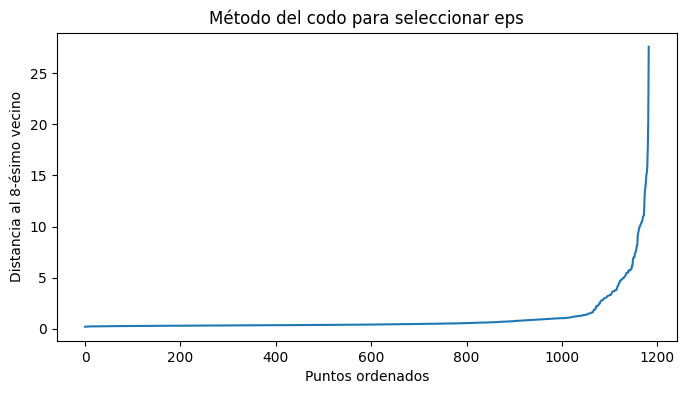

In [147]:
# 11. Calcular el radio óptimo de vecindad para nuestro algoritmo DBSCAN

min_samples = df_scaled.shape[1] + 1

neighbors = NearestNeighbors(n_neighbors=min_samples)
neighbors_fit = neighbors.fit(df_scaled)
distances, indices = neighbors_fit.kneighbors(df_scaled)

# Tomamos la distancia al k-ésimo vecino
distances_k = np.sort(distances[:, -1])

plt.figure(figsize=(8,4))
plt.plot(distances_k)
plt.xlabel("Puntos ordenados")
plt.ylabel(f"Distancia al {min_samples}-ésimo vecino")
plt.title("Método del codo para seleccionar eps")
plt.show()

Como se puede observar en el gráfico, la reducción de la inercia comienza a desacelerarse notablemente a partir de un radio de vecindad (eps) de aproximadamente 5. Por ello, utilizaremos este valor como parámetro para DBSCAN, junto con el min_samples previamente definido, para identificar clusters densos en nuestro dataset.

In [148]:
# 12. Construir los modelos a partir de los algoritmos que vamos a usar, para entender claramente cuál sería el mejor en nuestro caso

models = {
    "K-Means": KMeans(n_clusters=2, random_state=0),
    "DBSCAN": DBSCAN(eps=5, min_samples=(df_scaled.shape[1] + 1)),
    "GMM": GaussianMixture(n_components=2, random_state=0)
}

X = df_scaled.values # Importante pasar los datos a un array NumPy para evitar errores y conflictos con ciertos algoritmos
results = {}

# Recorrer los modelos y visualizar las salidas

for model_name, model in models.items():
    
    labels = model.fit_predict(X)
    
    # DBSCAN requiere calcular Silhouette y Davies-Bouldin solo para los puntos que NO son ruido, no omitirlo

    if model_name == "DBSCAN":
        
        mask = labels != -1 # Filtro para tener en True aquellos labels no outliers
        
        if len(set(labels[mask])) > 1: # Hay más de un clúster sin contar el ruido
            
            score_sil = silhouette_score(X[mask], labels=labels[mask])
            score_davies = davies_bouldin_score(X[mask], labels=labels[mask])
        
        else:
            
            score_sil = np.nan
            score_davies = np.nan

    else:
        
        score_sil = silhouette_score(X, labels=labels)
        score_davies = davies_bouldin_score(X, labels=labels)
    
    results[model_name] = { 
        "labels": labels, 
        "silhouette": score_sil,
        "davies-bouldin": score_davies
    }

# Clúster Jerárquico

Z = sch.linkage(X, method="ward") # Devuelve una matriz, no un modelo
labels_hier = sch.fcluster(Z, t=2, criterion="maxclust")

results["Clúster Jerárquico"] = {
    "labels": labels_hier,
    "silhouette": silhouette_score(X, labels_hier),
    "davies-bouldin": davies_bouldin_score(X, labels_hier)
}

Una vez entrenados todos los modelos, procedemos a visualizar las métricas de evaluación.

In [149]:
# 13. Visualizar las métricas de evaluación

for result_name, result in results.items():
    print(f"Modelo: {result_name} | Silhouette Score: {result['silhouette']} | Davies-Bouldin Index: {result['davies-bouldin']}")

Modelo: K-Means | Silhouette Score: 0.8753397164541254 | Davies-Bouldin Index: 0.5157732786331726
Modelo: DBSCAN | Silhouette Score: 0.8969034376187923 | Davies-Bouldin Index: 0.3165059930432659
Modelo: GMM | Silhouette Score: 0.7414239740831873 | Davies-Bouldin Index: 0.9801916453970145
Modelo: Clúster Jerárquico | Silhouette Score: 0.8751963930030734 | Davies-Bouldin Index: 0.5190419821201993


Como podemos observar según las métricas de evaluación, **nuestro modelo DBSCAN es el que obtiene la mejor puntuación**, tanto en Silhouette Score (más cercano a 1, lo que indica que los puntos están bien agrupados con respecto a los demás) como en Davies-Bouldin Index (más bajo, lo que refleja clusters más compactos y mejor separados).

No obstante, K-Means y el Clúster Jerárquico siguen siendo algoritmos adecuados para nuestro dataset, por lo que tampoco pueden descartarse.

Por último, GMM se posiciona como el modelo con peores métricas, mostrando menor capacidad para agrupar correctamente los datos de nuestro conjunto.

In [150]:
# 14. Mostrar las salidas del mejor modelo para nuestro dataset

X = df_scaled.values
best_model = DBSCAN(eps=5, min_samples=(df_scaled.shape[1] + 1))
labels = best_model.fit_predict(X)

unique, counts = np.unique(labels, return_counts=True)
print(f"Número de valores en cada clúster (-1 es ruido): {dict(zip(unique, counts))}")

Número de valores en cada clúster (-1 es ruido): {np.int64(-1): np.int64(31), np.int64(0): np.int64(1072), np.int64(1): np.int64(37), np.int64(2): np.int64(35), np.int64(3): np.int64(8)}


A pesar de que DBSCAN obtiene las mejores puntuaciones tanto en Silhouette Score como en Davies-Bouldin Index, podemos observar que las muestras se han agrupado en 4 clústers diferentes (sin contar el ruido), lo cual difiere del resultado obtenido mediante el cálculo de la desaceleración de inercia en K-Means, que indicaba 2 clústers óptimos.

Esta discrepancia puede generar cierta confusión, pero se debe a que DBSCAN no forma clusters en función de un número fijo, sino que depende de la densidad de cada punto y del radio de vecindad seleccionado previamente. Por lo tanto, el número de agrupaciones que encuentra DBSCAN durante el entrenamiento puede diferir significativamente del que encuentra K-Means.

Los 4 clusters resultantes pueden interpretarse de la siguiente manera:

* Clúster 0 --> Vueltas rápidas “estables”.
* Clúster 1 --> Vueltas lentas “estables”.
* Clúster 2 --> Vueltas rápidas con cierta variabilidad (por ejemplo, debido a la aparición del Safety Car o cambios en las condiciones de pista).
* Clúster 3 --> Vueltas lentas con errores leves de conducción.

Del análisis de las cantidades de vueltas por clúster, se observa que el Clúster 0 contiene 1072 vueltas, siendo el grupo más grande. Esto confirma que la mayoría de las vueltas se mantienen dentro de un patrón de vueltas rápidas estables, mientras que los otros clústers representan subconjuntos más pequeños con variaciones o errores leves, y el ruido identifica vueltas atípicas.

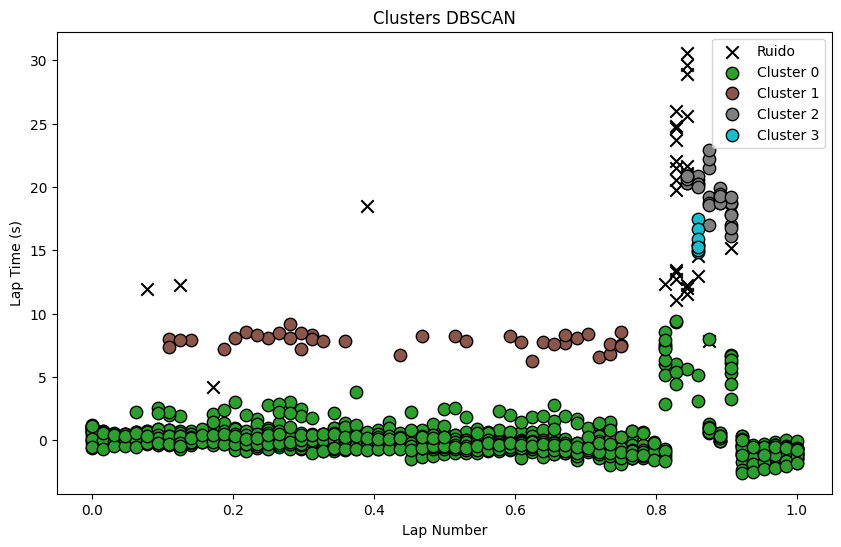

In [151]:
# 15. Gráfica de DBSCAN

# Colores: un color por cluster, -1 será negro para el ruido

unique_labels = np.unique(labels)
cmap = plt.get_cmap("tab10")
colors = cmap(np.linspace(0, 1, len(unique_labels)))

plt.figure(figsize=(10, 6))

for k, col in zip(unique_labels, colors):
    
    class_member_mask = (labels == k)
    
    if k == -1:
        
        col = 'k'
        marker = 'x'
        
        plt.scatter(
            X[class_member_mask, 0],
            X[class_member_mask, 1],
            c=[col],
            marker=marker,
            label='Ruido',
            s=80 
        )

    else:
        
        plt.scatter(
            X[class_member_mask, 0],
            X[class_member_mask, 1],
            c=[col],
            marker='o',
            label=f'Cluster {k}',
            edgecolor='k',
            s=80
        )

plt.xlabel('Lap Number')
plt.ylabel('Lap Time (s)')
plt.title('Clusters DBSCAN')
plt.legend()
plt.show()

# **RESULTADO FINAL:** MODELO DE APRENDIZAJE NO SUPERVISADO UTILIZANDO UN ALGORITMO DE DBSCAN

Tras un exhaustivo proceso de tratamiento de los datos y evaluación de distintos modelos, se ha observado que el algoritmo DBSCAN es el más eficiente para resolver este problema. Según los resultados obtenidos, este modelo ofrece un alto rendimiento al identificar tanto el número de clústers como la densidad de cada uno de ellos.

Aunque otros algoritmos como K-Means o el Clúster Jerárquico pueden presentar resultados similares, se opta finalmente por DBSCAN, ya que es el modelo con mejores métricas de evaluación, tanto en Silhouette Score como en Davies-Bouldin Index. En particular, un Silhouette Score de 0,89 indica que los puntos dentro de cada clúster están muy bien agrupados y los clústers están claramente separados.

No obstante, todo modelo es susceptible de mejora. Algunas posibles estrategias incluyen:

* Ampliar y enriquecer el dataset: Incorporar nuevas features que reflejen con mayor precisión el rendimiento real del coche durante cada vuelta, como la velocidad media, el tipo de neumático o el número de correcciones de volante.

* Validación cruzada y pruebas en distintos escenarios: Evaluar el modelo con diferentes sets de datos (por ejemplo, distintas sesiones o circuitos) para garantizar que los clústers sean consistentes y generalizables.

Estas acciones permitirían aumentar la exactitud del modelo y generar agrupaciones más precisas y representativas del comportamiento de los coches en pista.